# Credits

* **Author** : Aurelio Murolo ;
* **Date** : March, 2025 ;
* **Git-Hub** : [University Project Repository](https://github.com/AurelioMurolo/University-Projects) .

# Modules Import & Agnostic Device Setting

In [1]:
# Must
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import string
from math import log

# Sci-kit
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap
import umap
import scipy.stats as stats

# nltk
import nltk
from nltk.corpus import brown
from nltk.probability import *
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Model
import torch
from torch import nn

!pip install -q torchinfo
from torchinfo import summary
!pip install -q torchmetrics
from torchmetrics.regression import MeanSquaredError

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 50.3 MB/s eta 0:00:00


In [2]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print("The available device is: ", device)

The available device is:  cpu


# Code Reproducibility

In according to the official documentation about [Reproducibility](https://pytorch.org/docs/stable/notes/randomness.html):

> As long as `torch.manual_seed()` is set to a constant at the beginning of an application and all **other sources of nondeterminism** have been eliminated, the same series of random numbers will be generated each time the application is run in the same environment.

The other sources of nondeterminism include both the seeds of other libraries and the intrinsical randomness of the algorithms used by Pytorch for its operations.

Although a good reproducibility may cause a decrese both in performances and speed, it gurantees the optimal condition for the experimentations, Galileo Galilei *docet* . In order to decrees the non - deterministic behaviour we can run the following line of code.





In [3]:
seed = 42

# Torch
torch.manual_seed(seed)  # Seed for both CPU and GPU
torch.cuda.manual_seed(seed)  # Seed for GPU random number generation
torch.cuda.manual_seed_all(seed)  # For multi-GPU

torch.backends.cudnn.benchmark = False  # Deterministically select an algorithm
torch.backends.cudnn.deterministic = False # if only nondeterministic algorithms are available they will throw a RuntimeError when called
torch.Generator().manual_seed(seed)  # Seed for batch shuffling

# Numpy
np.random.seed(seed)

# Python
random.seed(seed)

You can find the full list of the normally-nondeterministic operations that will act deterministically when `torch.backends.cudnn.deterministic = True` at the following [link](https://pytorch.org/docs/stable/generated/torch.use_deterministic_algorithms.html#torch.use_deterministic_algorithms) .

In the end it's important to underline that it sufficient to call all the above functions only once at the beginning of the script, especially on a Jupyter Notebook like this where sometimes there are some "mis-comunication" among the cell of code. Anyway as you will se i still called them toI do it to avoid any possible problems.

# Text Data

In [4]:
nltk.download(['brown','stopwords','punkt_tab'], quiet = True)

True

Lets'consider one of the document the **Brown Corpus** as our Text of interest.

In [5]:
raw_sentence_Text = list(brown.sents(categories = ['hobbies']))
raw_word_Text = list(brown.words(categories = ['hobbies']))
raw_Text = str([' '.join(sent) for sent in raw_sentence_Text])

It is good practice to remove both stopwords and punctuation from the text since we do not want to encode them in the vast majority of the application.

The aim of the notebook is to put the attention on the **Continuos Bag of Word** model, so the data cleaning will be quite rough.

In [6]:
eng_stopwords = stopwords.words('english') # 198 stopwords
punctuations_set = set(string.punctuation) # 32 punctation char

In [7]:
' '.join(list(raw_sentence_Text[2]))

"After all , a guy's gotta have a little ego ! !"

In [8]:
clean_sentence_Text = []
for sent in raw_sentence_Text:
  sent = ' '.join(sent).lower()
  word_tokenized = word_tokenize(sent)
  word_filtered_sent = [word for word in word_tokenized if word not in eng_stopwords and word not in punctuations_set]
  clean_sentence_Text.append(word_filtered_sent)

In [9]:
clean_sentence_Text[2]

['guy', "'s", 'got', 'ta', 'little', 'ego']

We could also consider the ```raw_word_Text``` without taking into account the end of a statement.




In [10]:
word_filtered = [word for word in raw_word_Text if word not in eng_stopwords and word not in punctuations_set]
word_filtered = [word.lower() for word in word_filtered]

# CBoW Model

This model allow to build a static embedding by training a classifier to predict a **target word** given its context. In our case, as many empirical results suggest, we will consider the previous and the next two words w.r.t our target as context.

* $$∀ w_i ∈ \text{Corpus} \implies \text{Context} = [w_{i-2},w_{i-1},w_{i+1}, w_{i+2}]$$

The objective is to minimize the quantity:
* $$ \newcommand{\Softmax}{\operatorname{Softmax}}
-\log{p(w_i|C)}=-\log{\Softmax({A(\sum_{w\in C}q_w)+b)}} $$
  * $$q_w = w_{\text{one_hot}}E$$

In order to implement these operation we need:

1. **Embedding Layer** to map our one-hot-encoded words to the embedding space;
2. **Pooling Operation** (average,argmax,sum) to express the context of a given word as a unique vector;
3. **Linear Embedding** for evaluating the parameters of the model and compute the logits;
4. **Softmax** as activation function to express in probabilistic terms the result.

## Architecture

In [11]:
class CBOW(nn.Module):
  def __init__(self, vocab_size : int, embedding_dim : int):
    super().__init__()

    self.embeddings = nn.Embedding(vocab_size, embedding_dim) # w_onehot * E = q_w
    self.linear = nn.Linear(embedding_dim, vocab_size)        # A * q_w + b = logits

  def forward(self, inputs):
    # inputs : batch_size x 2 * Context
    # embeds : batch_size x 2 * Context x embedding_dim
    # Pooled_embeds : batch_size x embedding_dim
    inputs = inputs.long()
    embeds = self.embeddings(inputs)
    Pooled_embeds = torch.mean(embeds, dim = 1).squeeze(dim = 1)
    return self.linear(Pooled_embeds)

In [12]:
vocab_size = len(set(word_filtered))
embedding_dim = 128

Model_CBOW = CBOW(vocab_size = vocab_size, embedding_dim = embedding_dim).to(device)

This `nn.CrossEntropyLoss()` computes the cross entropy loss between input logits and target.



In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(Model_CBOW.parameters(), lr = 0.001)
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

In [14]:
Model_CBOW

CBOW(
  (embeddings): Embedding(10768, 128)
  (linear): Linear(in_features=128, out_features=10768, bias=True)
)

In [15]:
Initial_Embedding = Model_CBOW.embeddings.weight

## Data Pre - Processing

In [16]:
CONTEXT_SIZE = 2
vocab = set(word_filtered)
vocab_size = len(vocab)

word_to_ix = {word: i for i, word in enumerate(vocab)} # Mapping
ix_to_word = {i: word for i, word in enumerate(vocab)} # Inverse Mapping

The code below generates all the context-target pairs from the corpus.

In [17]:
data = []
for i in range(CONTEXT_SIZE, len(word_filtered) - CONTEXT_SIZE):
    context = ([word_filtered[i - j - 1] for j in range(CONTEXT_SIZE)] +
               [word_filtered[i + j + 1] for j in range(CONTEXT_SIZE)])
    target = word_filtered[i]

    data.append((context, target))

The last step is to express these pairs using the vocabulary indices.

In [18]:
def make_context_vector(context, word_to_ix):
    idxs = [word_to_ix[w] for w in context]
    return list(idxs)
def make_target_vector(target, word_to_ix):
    return [word_to_ix[target]]

In [19]:
for n in range(5):
  print('Context: ', data[n][0],' ---> ', make_context_vector(data[n][0], word_to_ix))
  print('Target: ', data[n][1], ' ---> ', make_target_vector(data[n][1],word_to_ix))
  print('\n')

Context:  ['often', 'too', 'bodybuilder', 'training']  --->  [5140, 5596, 558, 6106]
Target:  beginning  --->  [2948]


Context:  ['beginning', 'often', 'training', 'secretly']  --->  [2948, 5140, 6106, 9973]
Target:  bodybuilder  --->  [558]


Context:  ['bodybuilder', 'beginning', 'secretly', 'either']  --->  [558, 2948, 9973, 4028]
Target:  training  --->  [6106]


Context:  ['training', 'bodybuilder', 'either', 'parents']  --->  [6106, 558, 4028, 8122]
Target:  secretly  --->  [9973]


Context:  ['secretly', 'training', 'parents', 'want']  --->  [9973, 6106, 8122, 8133]
Target:  either  --->  [4028]




Now it's time to compute the whole dataset.

In [20]:
N = len(data) # 43584 pairs of (context, target)

In [21]:
context_data = []
target_data = []
for contex in range(N):
  context = make_context_vector(data[contex][0], word_to_ix)
  target = make_target_vector(data[contex][1], word_to_ix)
  context_data.append(context)
  target_data.append(target)

In [22]:
context_data = torch.tensor(context_data, dtype = torch.long).to(device)
target_data = torch.tensor(target_data, dtype = torch.long).to(device)

In [23]:
type(context_data[0]), type(target_data[0])

(torch.Tensor, torch.Tensor)

Finally we will use the dataset below:

In [24]:
batch_size = 128
Dataset = torch.utils.data.TensorDataset(context_data, target_data)
Dataset_loader = torch.utils.data.DataLoader(Dataset, batch_size = batch_size, shuffle = True)
print('There will be :', len(Dataset_loader), 'batches for each epoch')

There will be : 341 batches for each epoch


In [25]:
# Check of data shape
train_contex, train_target = next(iter(Dataset_loader))
print(f"Context batch shape: {train_contex.size()}")
print(f"Target batch shape: {train_target.size()}")

Context batch shape: torch.Size([128, 4])
Target batch shape: torch.Size([128, 1])


## Training


In [26]:
torch.manual_seed(seed)
epochs = 50

In [27]:
%%time
# Inizialize the model for each training Loop
Model_CBOW = CBOW(vocab_size = vocab_size, embedding_dim = embedding_dim).to(device)
optimizer = torch.optim.Adam(Model_CBOW.parameters(), lr = 0.001)

# Training Loop
losses = []
for epoch in range(epochs + 1):
  for context, target in Dataset_loader:
    Model_CBOW.train()
    logits = Model_CBOW(context)
    probabilties = torch.softmax(logits, dim = 1)

    loss = loss_fn(logits, target.squeeze(dim = 1))
    acc = accuracy_fn(target.squeeze(dim = 1), probabilties.squeeze(dim = 1).argmax(dim = 1))


    # Pytorch Workflow
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  losses.append(loss.item())

  if epoch % 10 == 0:
    print('Epoch: ', epoch,' --- ', 'Loss: ', loss.item(),' --- ', 'Accuracy: ',str(round(acc)) + '%')

Epoch:  0  ---  Loss:  9.088160514831543  ---  Accuracy:  2%
Epoch:  10  ---  Loss:  3.474339246749878  ---  Accuracy:  48%
Epoch:  20  ---  Loss:  1.1148344278335571  ---  Accuracy:  84%
Epoch:  30  ---  Loss:  0.7041338682174683  ---  Accuracy:  92%
Epoch:  40  ---  Loss:  0.16703465580940247  ---  Accuracy:  98%
Epoch:  50  ---  Loss:  0.04392135515809059  ---  Accuracy:  100%
CPU times: user 17min 56s, sys: 2min 10s, total: 20min 6s
Wall time: 22min 7s


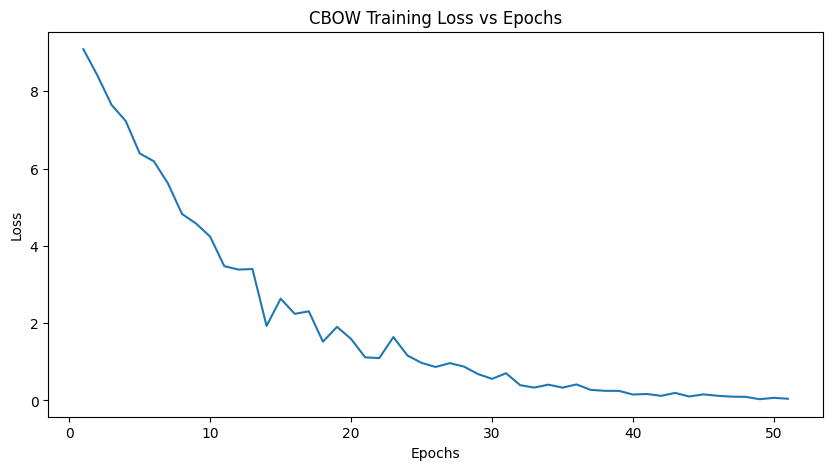

In [28]:
epochs = np.arange(1, len(losses) + 1)
losses = np.array(losses)

plt.figure(figsize = (10,5))
plt.plot(epochs, losses)
plt.title('CBOW Training Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## Model Summary

Now, there exists one library called [torchsummary](https://pypi.org/project/torch-summary/) but, as you can read at the link, torch-summary has been renamed to [torchinfo]().

Torchinfo provides information complementary to what is provided by `print(your_model)` in PyTorch, similar to Tensorflow's `model.summary()` API to view the visualization of the model, which is helpful while debugging your network.

In [29]:
input_dimension = 2 * CONTEXT_SIZE

In [30]:
summary(Model_CBOW,
        input_size = (batch_size , input_dimension),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        mode = 'train',
        col_width = 20,
        depth = 3,
        row_settings=["var_names"],
        verbose = 2)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
CBOW (CBOW)                              [128, 4]             [128, 10768]         --                   True
├─Embedding (embeddings)                 [128, 4]             [128, 4, 128]        1,378,304            True
│    └─weight                                                                      └─1,378,304
├─Linear (linear)                        [128, 128]           [128, 10768]         1,389,072            True
│    └─weight                                                                      ├─1,378,304
│    └─bias                                                                        └─10,768
Total params: 2,767,376
Trainable params: 2,767,376
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 354.22
Input size (MB): 0.00
Forward/backward pass size (MB): 11.55
Params size (MB): 11.07
Estimated Total Size (MB): 22.62


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
CBOW (CBOW)                              [128, 4]             [128, 10768]         --                   True
├─Embedding (embeddings)                 [128, 4]             [128, 4, 128]        1,378,304            True
│    └─weight                                                                      └─1,378,304
├─Linear (linear)                        [128, 128]           [128, 10768]         1,389,072            True
│    └─weight                                                                      ├─1,378,304
│    └─bias                                                                        └─10,768
Total params: 2,767,376
Trainable params: 2,767,376
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 354.22
Input size (MB): 0.00
Forward/backward pass size (MB): 11.55
Params size (MB): 11.07
Estimated Total Size (MB): 22.62

## Final Embedding

In the end we can extract the resulting **Embedding** after the training stage.

In [31]:
Final_Embedding = Model_CBOW.embeddings.weight

In [32]:
print('The shape of the final embedding is: ', Final_Embedding.shape)
print('The shape of the intial embedding is: ', Initial_Embedding.shape)

The shape of the final embedding is:  torch.Size([10768, 128])
The shape of the intial embedding is:  torch.Size([10768, 128])


In [33]:
# For illustration purpose
Initial_Embedding = Initial_Embedding.detach().cpu().numpy()
Final_Embedding = Final_Embedding.detach().cpu().numpy()

In [34]:
for embedded_word in range(3):
  print('E_in : ', Initial_Embedding[embedded_word, : 3], ' ---> ', 'E_out: ', Final_Embedding[embedded_word, : 3])
  print('\n')

E_in :  [1.9269153 1.4872841 0.9007172]  --->  E_out:  [ 2.6224136   0.53071046 -0.25637984]


E_in :  [ 1.9311606  1.0118638 -1.4364065]  --->  E_out:  [ 2.961334   1.7547554 -1.4392612]


E_in :  [-0.6854816  0.563559  -1.5071751]  --->  E_out:  [-0.33269918  0.7925125  -1.6665779 ]




# Word2Vec Visualization

The last step is to rappresent our embedded words in a lower dimensional vectorial space in order to analyze their geometrical properties. Lets'take a look of our `Final_Embedding` variable :

In [35]:
Final_Embedding.shape, Final_Embedding.dtype, type(Final_Embedding)

((10768, 128), dtype('float32'), numpy.ndarray)

The goal is to find the optimal rappresentation of the data in a **$2$-Dimensional Vectorial Space**, in other terms:
* $$col(E)\in ℜ^{128}→ col(\tilde{E}) \in ℜ^2$$

In [36]:
# Count positive elements
num_positive = np.sum(Final_Embedding > 0)
total_elements = Final_Embedding.size

# Relative number of positive elements
relative_positive = num_positive / total_elements

print("Relative number of positive elements:", round(relative_positive,3))

Relative number of positive elements: 0.499


This result has an impact on the choice of the optimal activation function to put in the **AutoEncoder**.

Min: -6.787
Max: 7.579
Mean +\- Std= -0.008  +\-  1.3


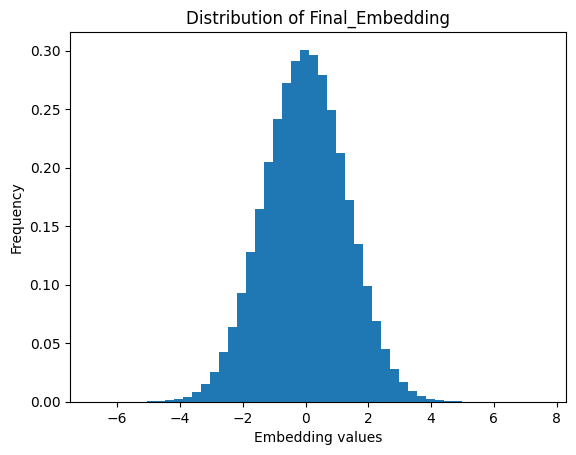

In [37]:
embedding_flat = torch.tensor(Final_Embedding).view(-1)  # flatten the tensor
min_val = torch.min(embedding_flat).item()
max_val = torch.max(embedding_flat).item()
mean_val = torch.mean(embedding_flat).item()
std_val = torch.std(embedding_flat).item()

print("Min:", round(min_val,3))
print("Max:", round(max_val,3))
print("Mean +\- Std=", round(mean_val,3),' +\- ', round(std_val,1))

# Plot the histogram
plt.hist(embedding_flat.cpu().numpy(), bins=50, density = True)
plt.xlabel("Embedding values")
plt.ylabel("Frequency")
plt.title("Distribution of Final_Embedding")
plt.show()

In [38]:
embedding_np = embedding_flat.cpu().numpy()

# D'Agostino's K-squared test
dagostino_stat, dagostino_p = stats.normaltest(embedding_np)
print("\nD'Agostino's K-squared Test:")
print("Statistic:", round(dagostino_stat,3), "p-value:", round(dagostino_p,3))
if dagostino_p > 0.05:
    print("Fail to reject H0: Data appears to be normally distributed.")
else:
    print("Reject H0: Data does not appear to be normally distributed.")


D'Agostino's K-squared Test:
Statistic: 373.435 p-value: 0.0
Reject H0: Data does not appear to be normally distributed.


## Data Dimensionality Reduction

In the following section we are goign to find the optimal way to rapresent our data in a **2-D** space. We will use $4$ different algorithms in this order, from the simplest to the most complex one :
1. **PCA**

2. **UMAP**

3. **TSNE**

4. **FF AUTOENCODER**

### Principal Component Analysis

It is the well known linear dimensionality reduction based on using **Singular Value Decomposition** of the data to project it to a lower dimensional space. Explore the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) for further information.

In [39]:
PCA_model = PCA(n_components = 2, random_state = seed)
Reduced_Embeddings = PCA_model.fit_transform(Final_Embedding)

In [40]:
Principal_components = PCA_model.components_
Explained_Var = PCA_model.explained_variance_

print('The shape of the principal components is: ', Principal_components.shape)
print('The explained variance is: ', (Explained_Var).round(2))

The shape of the principal components is:  (2, 128)
The explained variance is:  [2.57 2.2 ]


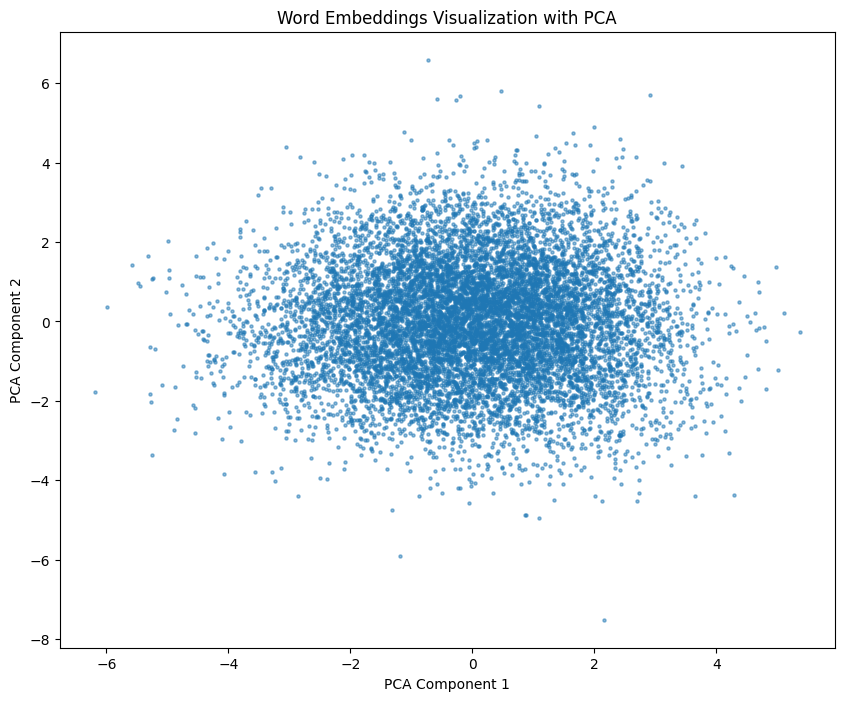

In [41]:
plt.figure(figsize=(10, 8))
plt.scatter(Reduced_Embeddings[:, 0], Reduced_Embeddings[:, 1], s = 5, alpha=0.5)
plt.title('Word Embeddings Visualization with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

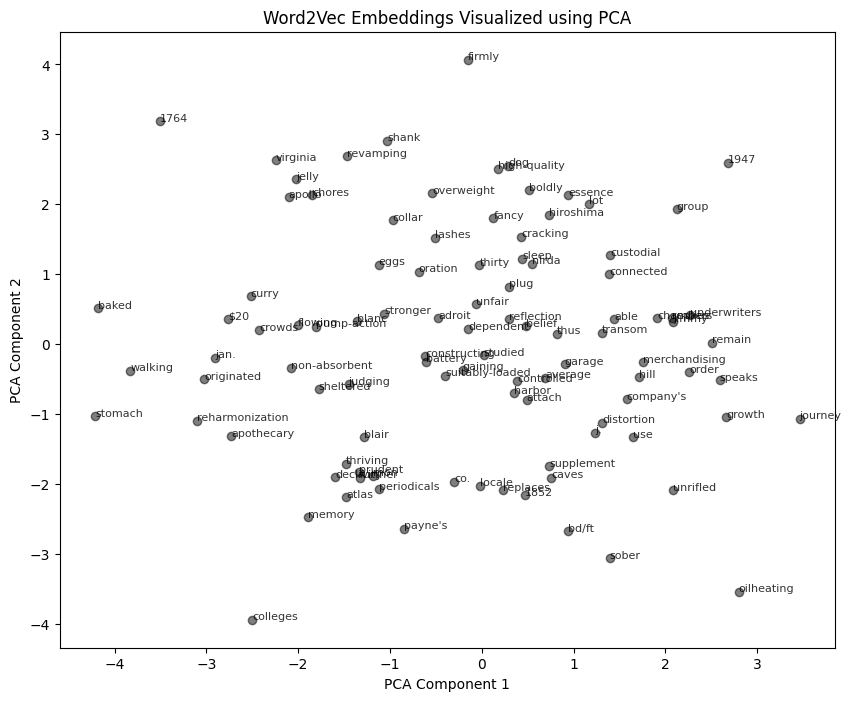

In [42]:
plt.figure(figsize=(10, 8))
for i in range(min(100, len(Reduced_Embeddings))):
    word = ix_to_word.get(i, None)
    if word:
      plt.annotate(word, (Reduced_Embeddings[i, 0], Reduced_Embeddings[i, 1]), fontsize = 8, alpha = 0.8)
      plt.scatter(Reduced_Embeddings[i, 0], Reduced_Embeddings[i, 1], c = 'black', alpha = 0.5)


plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Word2Vec Embeddings Visualized using PCA")
plt.show()

### UMAP

In order to understand the setted parameter, you can visit the [UMAP](https://umap-learn.readthedocs.io/en/latest/parameters.html) documentation.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


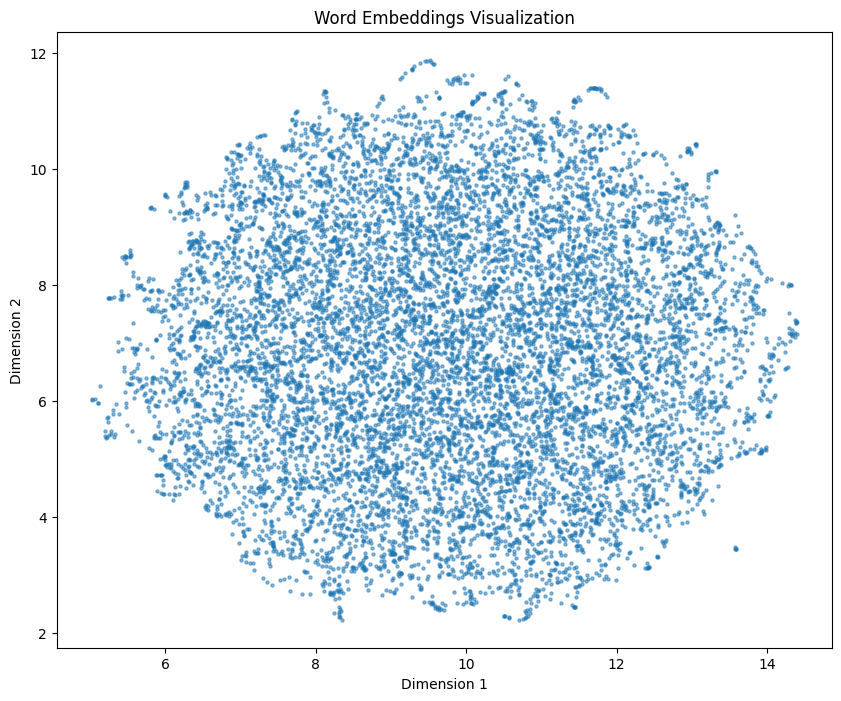

In [43]:
umap_reducer = umap.UMAP(n_components = 2,
                         random_state = seed,
                         n_neighbors = 2 * CONTEXT_SIZE,
                         metric = 'cosine')
reduced_embeddings_umap = umap_reducer.fit_transform(Final_Embedding)

# Plotting UMAP
plt.figure(figsize=(10, 8))
plt.scatter(reduced_embeddings_umap[:, 0], reduced_embeddings_umap[:, 1], s = 5, alpha = 0.5)
plt.title('Word Embeddings Visualization')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

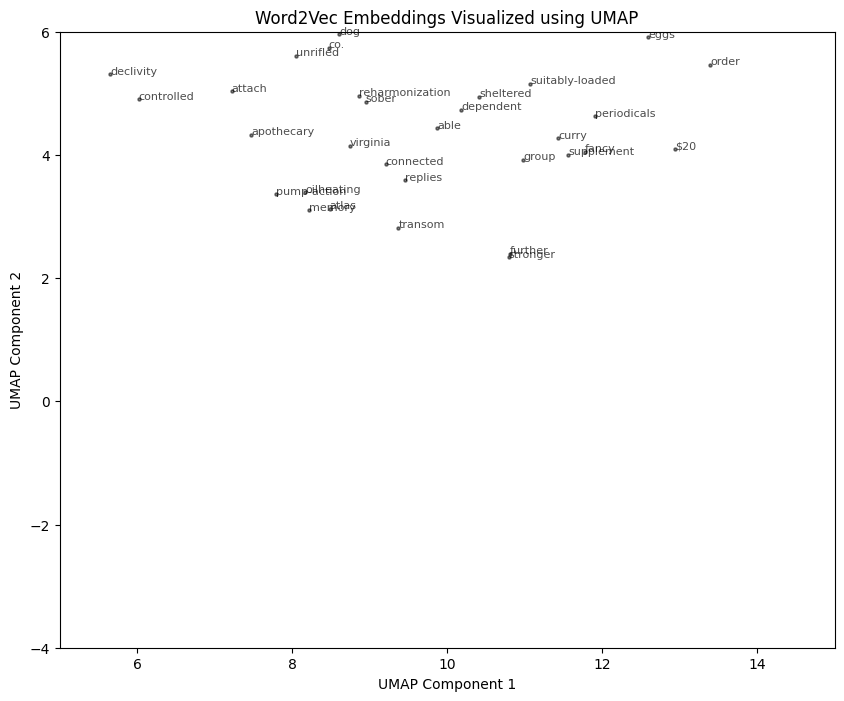

In [44]:
plt.figure(figsize=(10, 8))
for i in range(min(100, len(reduced_embeddings_umap))):
    word = ix_to_word.get(i, None)
    if word:
        plt.annotate(word, (reduced_embeddings_umap[i, 0], reduced_embeddings_umap[i, 1]), fontsize=8, alpha=0.7)
        plt.scatter(reduced_embeddings_umap[i, 0], reduced_embeddings_umap[i, 1], s=5, alpha=0.5, color='black')

plt.xlim(5, 15)
plt.ylim(-4, 6)
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.title("Word2Vec Embeddings Visualized using UMAP")
plt.show()

### T-SNE

In the same way as for UMAP, i suggest you to take a look at the [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) official documentation.

In [45]:
tsne = TSNE(n_components = 2,
            perplexity = 20,
            metric = 'cosine',
            learning_rate = 200,
            random_state = seed)
reduced_embeddings_tsne = tsne.fit_transform(Final_Embedding)

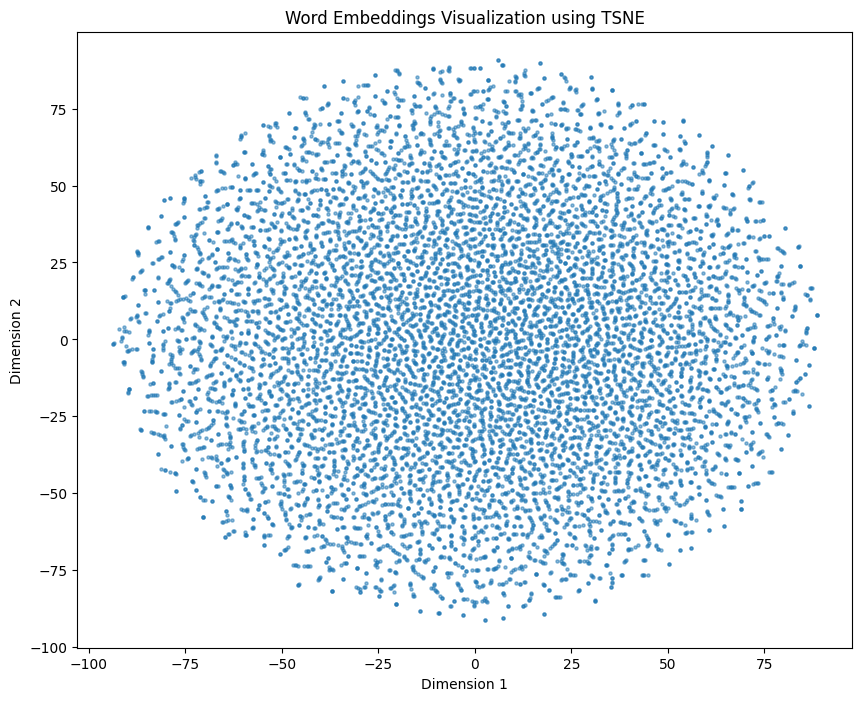

In [46]:
plt.figure(figsize=(10, 8))
plt.scatter(reduced_embeddings_tsne[:, 0], reduced_embeddings_tsne[:, 1], s = 5, alpha = 0.5)
plt.title('Word Embeddings Visualization using TSNE')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

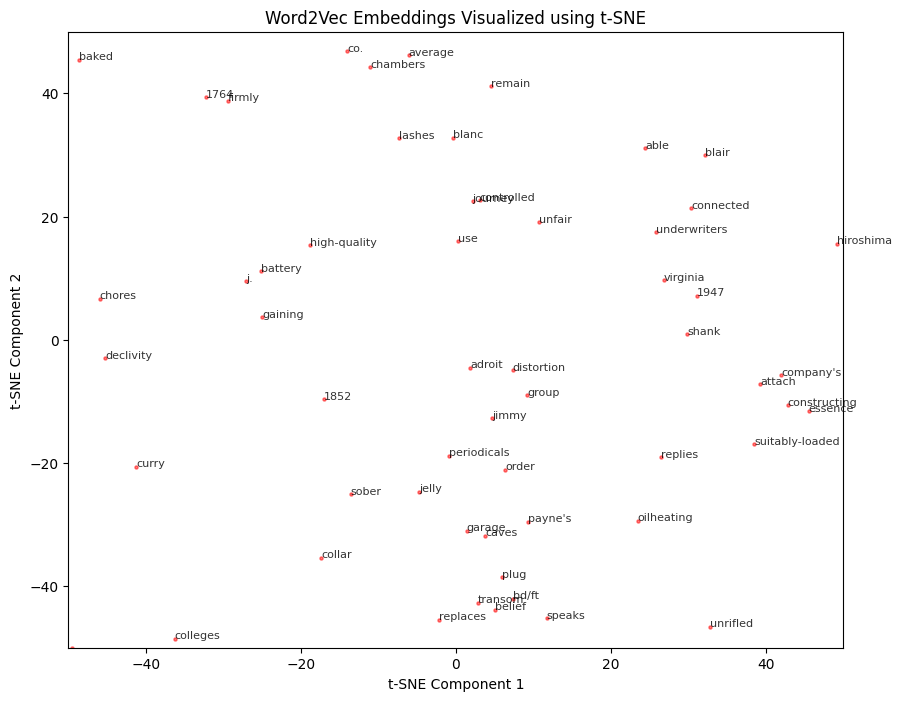

In [47]:
plt.figure(figsize=(10, 8))
for i in range(min(100, len(reduced_embeddings_tsne))):
    word = ix_to_word.get(i, None)
    if word:
        plt.annotate(word, (reduced_embeddings_tsne[i, 0], reduced_embeddings_tsne[i, 1]), fontsize = 8, alpha = 0.8)
        plt.scatter(reduced_embeddings_tsne[i, 0], reduced_embeddings_tsne[i, 1], s = 5, alpha = 0.5, color = 'red')

plt.xlim(-50, 50)
plt.ylim(-50, 50)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Word2Vec Embeddings Visualized using t-SNE")
plt.show()

### Feed Forward Autoencoder Architecture

First of all, in general we know that:

> *An autoencoder is a type of algorithm with the primary
purpose of learning an "informative" representation of the data that
can be used for different applicationsa
by learning to reconstruct a set
of input observations well enough.*



#### Architecture

In [62]:
# Encoder
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_128, hidden_64, hidden_32, hidden_16, hidden_8, hidden_4, latent_dim):
        super().__init__()
        self.input_layer = nn.Linear(input_dim, hidden_128)
        self.hidden_64 = nn.Linear(hidden_128, hidden_64)
        self.hidden_32 = nn.Linear(hidden_64, hidden_32)
        self.hidden_16 = nn.Linear(hidden_32, hidden_16)
        self.hidden_8 = nn.Linear(hidden_16, hidden_8)
        self.hidden_4 = nn.Linear(hidden_8, hidden_4)
        self.latent_layer = nn.Linear(hidden_4, latent_dim)

        self.Hardtanh = nn.Hardtanh(min_val = -1.0, max_val =1.0)
        self.leaky_relu = nn.LeakyReLU(negative_slope=1e-2)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.Hardtanh(self.input_layer(x))
        x = self.Hardtanh(self.hidden_64(x))
        x = self.Hardtanh(self.hidden_32(x))
        x = self.Hardtanh(self.hidden_16(x))
        x = self.tanh(self.hidden_8(x))
        x = self.tanh(self.hidden_4(x))
        latent_space = self.Hardtanh(self.latent_layer(x))

        return latent_space

# Decoder
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_4, hidden_8, hidden_16, hidden_32, hidden_64, hidden_128, output_dim):
        super().__init__()
        self.hidden_4 = nn.Linear(latent_dim, hidden_4)
        self.hidden_8 = nn.Linear(hidden_4, hidden_8)
        self.hidden_16 = nn.Linear(hidden_8, hidden_16)
        self.hidden_32 = nn.Linear(hidden_16, hidden_32)
        self.hidden_64 = nn.Linear(hidden_32, hidden_64)
        self.hidden_128 = nn.Linear(hidden_64, hidden_128)
        self.output_layer = nn.Linear(hidden_128, output_dim)

        self.leaky_relu = nn.LeakyReLU(negative_slope=1e-2)
        self.tanh = nn.Tanh()
        self.Hardtanh = nn.Hardtanh(min_val = -1.0, max_val =1.0)

    def forward(self, x):
        x = self.tanh(self.hidden_4(x))
        x = self.tanh(self.hidden_8(x))
        x = self.tanh(self.hidden_16(x))
        x = self.Hardtanh(self.hidden_32(x))
        x = self.Hardtanh(self.hidden_64(x))
        x = self.Hardtanh(self.hidden_128(x))
        output = self.tanh(self.output_layer(x))

        return output

# Autoencoder
class FF_Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_128, hidden_64, hidden_32, hidden_16, hidden_8, hidden_4, latent_dim):
        super().__init__()
        self.encoder = Encoder(input_dim, hidden_128, hidden_64, hidden_32, hidden_16, hidden_8, hidden_4, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_4, hidden_8, hidden_16, hidden_32, hidden_64, hidden_128, input_dim)

    def forward(self, x):
        latent_space = self.encoder(x)
        reconstructed = self.decoder(latent_space)

        return reconstructed, latent_space

We can also define it as a single class.

In [63]:
class FF_AE(nn.Module):
  def __init__(self, input_dim : int, hidden_128 : int, hidden_64 : int, hidden_32 :int, hidden_16: int,hidden_8 : int, hidden_4 : int , latent_dim : int):
    super().__init__()

    # Encoder
    self.input_layer = nn.Linear(input_dim, hidden_128)
    self.encoder_hidden_64 = nn.Linear(hidden_128, hidden_64)
    self.encoder_hidden_32 = nn.Linear(hidden_64, hidden_32)
    self.encoder_hidden_16 = nn.Linear(hidden_32, hidden_16)
    self.encoder_hidden_8 = nn.Linear(hidden_16, hidden_8)
    self.encoder_hidden_4 = nn.Linear(hidden_8, hidden_4)
    self.encoder_hidden_2 = nn.Linear(hidden_4, latent_dim)

    # Decoder
    self.decoder_hidden_2 = nn.Linear(latent_dim, hidden_4)
    self.decoder_hidden_4 = nn.Linear(hidden_4, hidden_8)
    self.decoder_hidden_8 = nn.Linear(hidden_8, hidden_16)
    self.decoder_hidden_16 = nn.Linear(hidden_16, hidden_32)
    self.decoder_hidden_32 = nn.Linear(hidden_32, hidden_64)
    self.decoder_hidden_64 = nn.Linear(hidden_64, hidden_128)
    self.decoder_hidden_128 = nn.Linear(hidden_128, input_dim)


    # Activation Function for non linearity
    self.tanh = nn.Tanh()
    self.leaky_relu = nn.LeakyReLU(negative_slope = 1e-2)
    self.Hardtanh = nn.Hardtanh(min_val = -1.0, max_val = 1.0)

  def forward(self, inputs):
    # Encoder Forward
    x = self.tanh(self.input_layer(inputs))
    x = self.Hardtanh(self.encoder_hidden_64(x))
    x = self.Hardtanh(self.encoder_hidden_32(x))
    x = self.tanh(self.encoder_hidden_16(x))
    x = self.tanh(self.encoder_hidden_8(x))
    x = self.tanh(self.encoder_hidden_4(x))

    # Latent Space
    latent_space = self.Hardtanh(self.encoder_hidden_2(x))

    # Decoder Forward
    x = self.tanh(self.decoder_hidden_2(latent_space))
    x = self.tanh(self.decoder_hidden_4(x))
    x = self.tanh(self.decoder_hidden_8(x))
    x = self.Hardtanh(self.decoder_hidden_16(x))
    x = self.Hardtanh(self.decoder_hidden_32(x))
    x = self.Hardtanh(self.decoder_hidden_64(x))
    output = self.tanh(self.decoder_hidden_128(x))

    return output, latent_space

In [64]:
FF_Autoencoder_model = FF_Autoencoder(input_dim = embedding_dim,
                                      hidden_128 = 128,
                                      hidden_64 = 64,
                                      hidden_32 = 32,
                                      hidden_16 = 16,
                                      hidden_8 = 8,
                                      hidden_4 = 4,
                                      latent_dim = 2).to(device)

In [65]:
loss = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(FF_Autoencoder_model.parameters(), lr = 0.005)
RE = MeanSquaredError().to(device)

In [66]:
Final_Embedding = MinMaxScaler(feature_range = (-1, 1)).fit_transform(Final_Embedding)

if Final_Embedding.dtype != torch.float32:
  Final_Embedding = torch.tensor(Final_Embedding, dtype = torch.float32)

Let's see the distribution of our input data to select the  activation function of the hidden layers. It is important to underline that the last activation function must be a **tanh** because of the distribution of the input data.

<ipython-input-67-48ddaabb962b>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embedding_flat = torch.tensor(Final_Embedding).clone().detach().view(-1)  # flatten the tensor


Min: -1.0
Max: 1.0
Mean +\- Std= -0.002  +\-  0.3


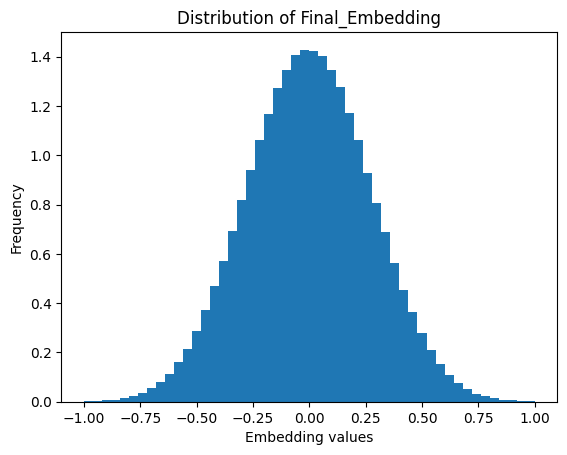

In [67]:
embedding_flat = torch.tensor(Final_Embedding).clone().detach().view(-1)  # flatten the tensor
min_val = torch.min(embedding_flat).item()
max_val = torch.max(embedding_flat).item()
mean_val = torch.mean(embedding_flat).item()
std_val = torch.std(embedding_flat).item()

print("Min:", round(min_val,3))
print("Max:", round(max_val,3))
print("Mean +\- Std=", round(mean_val,3),' +\- ', round(std_val,1))

# Plot the histogram
plt.hist(embedding_flat.cpu().numpy(), bins=50, density = True)
plt.xlabel("Embedding values")
plt.ylabel("Frequency")
plt.title("Distribution of Final_Embedding")
plt.show()

#### Training

In [68]:
epochs = 500
batch_size = 512
sigma = 0.05

In [69]:
print(type(Final_Embedding))

<class 'torch.Tensor'>


* **Feed Forward Denoisining AE with ADAM**

In [70]:
%%time
Embedding_Data = torch.utils.data.TensorDataset(Final_Embedding)
Embedding_Loader = torch.utils.data.DataLoader(Embedding_Data, batch_size = batch_size, shuffle = True) # list of tensor

# Inizializing Model & Optimizer
FF_Autoencoder_model = FF_Autoencoder(input_dim = embedding_dim,
                                           hidden_128 = 128,
                                           hidden_64 = 64,
                                           hidden_32 = 32,
                                           hidden_16 = 16,
                                           hidden_8 = 8,
                                           hidden_4 = 4,
                                           latent_dim = 2).to(device)

optimizer = torch.optim.Adam(FF_Autoencoder_model.parameters(), lr = 0.004, weight_decay = 1e-6)
RE = MeanSquaredError().to(device)

for epoch in range(epochs + 1):
  for embedded_batch in Embedding_Loader:
    embedded_batch = torch.stack(embedded_batch).to(torch.float32).to(device).squeeze() # [1, batch_size, 128] --> [batch_size, 128]

    # Noising
    noise = torch.randn_like(embedded_batch) * sigma
    embedded_batch_noisy = embedded_batch + noise

    FF_Autoencoder_model.train()
    logits, latent_space = FF_Autoencoder_model(embedded_batch_noisy)
    RE_value = RE(logits, embedded_batch)

    optimizer.zero_grad()
    RE_value.backward()
    optimizer.step()

  if epoch % 50 == 0:
        print(f"Epoch [{epoch}/{epochs}], Reconstruction Error: {RE_value.item():.4f}")

Epoch [0/500], Reconstruction Error: 0.0668
Epoch [50/500], Reconstruction Error: 0.0709
Epoch [100/500], Reconstruction Error: 0.0690
Epoch [150/500], Reconstruction Error: 0.0678
Epoch [200/500], Reconstruction Error: 0.0736
Epoch [250/500], Reconstruction Error: 0.0668
Epoch [300/500], Reconstruction Error: 0.0719
Epoch [350/500], Reconstruction Error: 0.0670
Epoch [400/500], Reconstruction Error: 0.0761
Epoch [450/500], Reconstruction Error: 0.0665
Epoch [500/500], Reconstruction Error: 0.0683
CPU times: user 3min 19s, sys: 424 ms, total: 3min 19s
Wall time: 3min 37s


*  **Feed Forward Denoisining AE with SGD**

In [71]:
epochs = 500
batch_size = 512
sigma = 0.05

In [72]:
%%time
Embedding_Data = torch.utils.data.TensorDataset(Final_Embedding)
Embedding_Loader = torch.utils.data.DataLoader(Embedding_Data, batch_size = batch_size, shuffle = True) # list of tensor

# Inizializing Model & Optimizer
FF_Autoencoder_model = FF_Autoencoder(input_dim = embedding_dim,
                                           hidden_128 = 128,
                                           hidden_64 = 64,
                                           hidden_32 = 32,
                                           hidden_16 = 16,
                                           hidden_8 = 8,
                                           hidden_4 = 4,
                                           latent_dim = 2).to(device)

optimizer = torch.optim.SGD(FF_Autoencoder_model.parameters(), lr = 0.005, momentum = 0.8, weight_decay=1e-6)
RE = MeanSquaredError().to(device)

for epoch in range(epochs + 1):
  for embedded_batch in Embedding_Loader:
    embedded_batch = torch.stack(embedded_batch).to(torch.float32).to(device).squeeze() # [1, batch_size, 128] --> [batch_size, 128]
    #print(embedded_batch.shape)

    # Noising
    noise = torch.randn_like(embedded_batch) * sigma
    embedded_batch_noisy = embedded_batch + noise

    FF_Autoencoder_model.train()
    logits, latent_space = FF_Autoencoder_model(embedded_batch_noisy)
    RE_value = RE(logits, embedded_batch)

    optimizer.zero_grad()
    RE_value.backward()
    optimizer.step()

  if epoch % 50 == 0:
        print(f"Epoch [{epoch}/{epochs}], Reconstruction Error: {RE_value.item():.4f}")

Epoch [0/500], Reconstruction Error: 0.0790
Epoch [50/500], Reconstruction Error: 0.0658
Epoch [100/500], Reconstruction Error: 0.0674
Epoch [150/500], Reconstruction Error: 0.0662
Epoch [200/500], Reconstruction Error: 0.0727
Epoch [250/500], Reconstruction Error: 0.0706
Epoch [300/500], Reconstruction Error: 0.0686
Epoch [350/500], Reconstruction Error: 0.0701
Epoch [400/500], Reconstruction Error: 0.0706
Epoch [450/500], Reconstruction Error: 0.0696
Epoch [500/500], Reconstruction Error: 0.0713
CPU times: user 2min 47s, sys: 404 ms, total: 2min 47s
Wall time: 3min 19s


#### Latent Space

Shape Embedding in latent space: torch.Size([10768, 2]) 



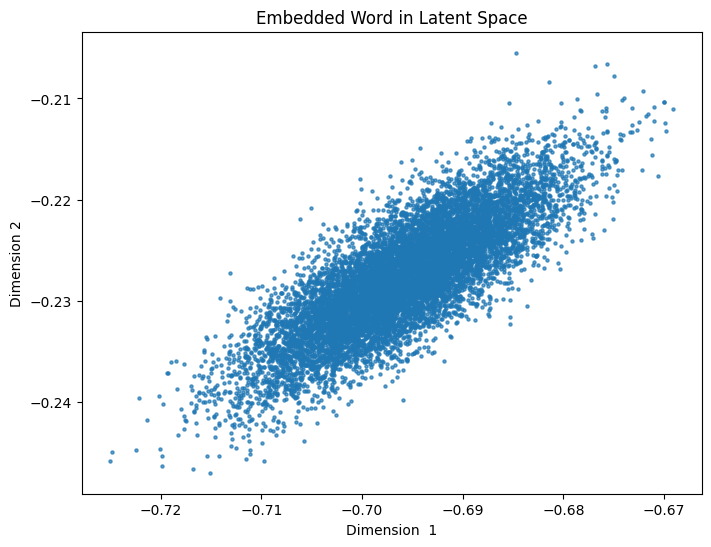

In [73]:
FF_Autoencoder_model.eval()
latent_representations = []

with torch.no_grad():
    for batch in Embedding_Loader:
        embedded_batch = batch[0].to(torch.float32).to(device)

        if embedded_batch.dim() == 3:
            embedded_batch = embedded_batch.squeeze(0)

        _, latent_batch = FF_Autoencoder_model(embedded_batch)

        latent_representations.append(latent_batch.cpu())

latent_representations = torch.cat(latent_representations, dim = 0)
print("Shape of Embedding in latent space:", latent_representations.shape,'\n')

plt.figure(figsize=(8, 6))
plt.scatter(latent_representations[:, 0], latent_representations[:, 1], s = 5, alpha = 0.7)
plt.xlabel("Dimension  1")
plt.ylabel("Dimension 2")
plt.title("Embedded Word in Latent Space")
plt.show()

#### Model Summary

In [79]:
FF_AE_summary = summary(FF_Autoencoder_model,
                        input_size = (batch_size , embedding_dim),
                        col_names=["input_size", "output_size", "num_params", "trainable"],
                        mode = 'train',
                        col_width = 20,
                        depth = 3,
                        row_settings=["var_names"],
                        verbose = 2)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
FF_Autoencoder (FF_Autoencoder)          [512, 128]           [512, 128]           --                   True
├─Encoder (encoder)                      [512, 128]           [512, 2]             --                   True
│    └─input_layer.weight                                                          ├─16,384
│    └─input_layer.bias                                                            ├─128
│    └─hidden_64.weight                                                            ├─8,192
│    └─hidden_64.bias                                                              ├─64
│    └─hidden_32.weight                                                            ├─2,048
│    └─hidden_32.bias                                                              ├─32
│    └─hidden_16.weight                                                            ├─512
│    └─hidden_16.bias                   